## Импорт библиотек

In [1]:
import PIL
from PIL import Image, ImageSequence
import imageio
import glob
import cv2

import numpy as np
import pandas as pd
import scipy.stats as sps
from numpy.linalg import norm

import hottbox as hb
from hottbox.core import Tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD
from hottbox.metrics import residual_rel_error

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [23]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 42

## Предобработка гифки

Разбиваем гифку покадрово

In [3]:
def split_gif_into_images(gif_path: str, 
                          out_path: str,
                          height: int,
                          width: int) -> None:
    gif = Image.open(gif_path)
    for idx, frame in enumerate(ImageSequence.Iterator(gif)):
        frame = frame.resize((height, width))
        frame.save(out_path + f"frame_{idx}.png")

        
HEIGHT = 128
WIDTH = 128

split_gif_into_images("duck.gif", "./duck-images/", HEIGHT, WIDTH)

Собираем все кадры воедино

In [4]:
def build_cartoon(frames_path: str, format_name: str = 'png', **imread_kwargs) -> np.array:
    cartoon = [] 

    for im_path in glob.glob(frames_path + f'*.{format_name}'):
        img = imageio.imread(im_path, **imread_kwargs)
        cartoon.append(img)
        
    return np.array(cartoon)

duck_cartoon = build_cartoon("./duck-images/", pilmode='L')

print("Duck:", duck_cartoon.shape)

Duck: (15, 128, 128)


Отрисовка начала гифки

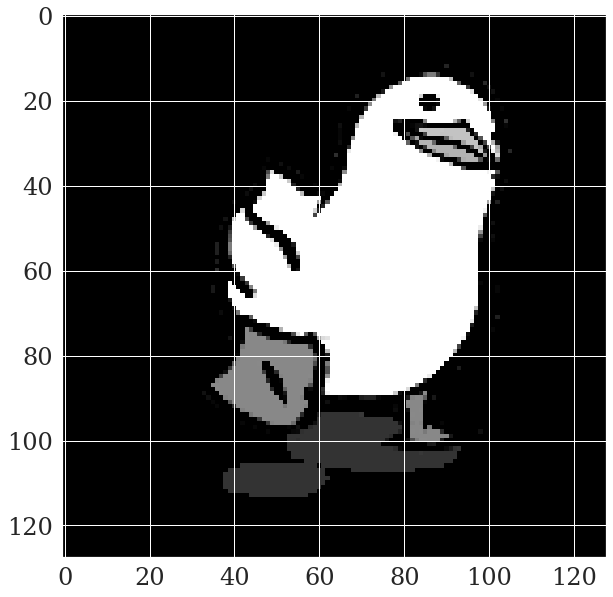

In [5]:
plt.figure(figsize=(10, 10))
plt.gray()
plt.imshow(duck_cartoon[0]);

## Применяем HOSVD к полученному тензору

Получение SVD разложения

In [8]:
def hosvd_transform(cartoon: np.array, core_shape: tuple):
    alg = HOSVD()
    cartoon_tensor = Tensor(cartoon.astype(float))
    tensor_tkd_hosvd = alg.decompose(cartoon_tensor, core_shape)

    factor_matrices = {}
    for mode, fmat in enumerate(tensor_tkd_hosvd.fmat):
        factor_matrices[mode] = fmat

    return tensor_tkd_hosvd, factor_matrices


tensor_tkd_hosvd, factor_matrices = hosvd_transform(duck_cartoon, 
                                                    (duck_cartoon.shape[0], 16, 16))

Визуализация восстановленной гифки

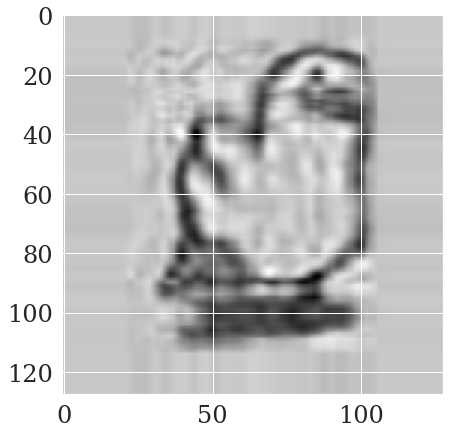

In [11]:
def print_recovered(recov_data):
    try:
        for i in range(len(recov_data)):
            clear_output(True)
            plt.gray()
            plt.imshow(recov_data[i])
            plt.show()
    except:
        pass


recov = (
    tensor_tkd_hosvd.core
    .mode_n_product(factor_matrices[0], mode=0, inplace=False)
    .mode_n_product(factor_matrices[1], mode=1, inplace=False)
    .mode_n_product(factor_matrices[2], mode=2, inplace=False)
)
print_recovered(recov.data)

Сохранение восстановленной гифки

In [19]:
# Конвертируем тензор из типа float к типу uint8 с помощью MinMaxScaling
normalized_recov = (recov.data - recov.data.max()) / (recov.data.max() - recov.data.min())
uint_recov = np.round(normalized_recov * 255).astype(np.uint8)

imageio.mimsave('duck_recov.gif', uint_recov)

Сравнение качества аппроксимации при различных размерах центрального тензора

Latent image size = (4, 4)


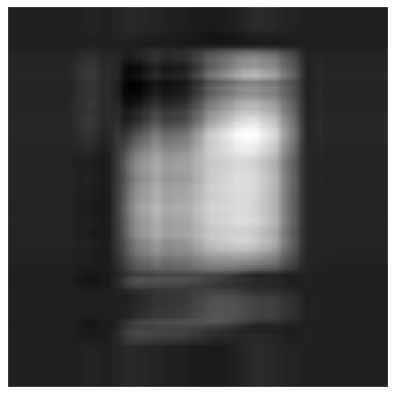

Latent image size = (8, 8)


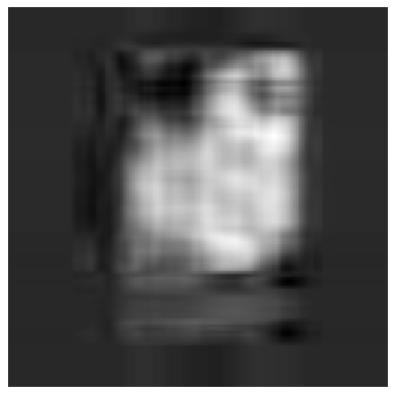

Latent image size = (12, 12)


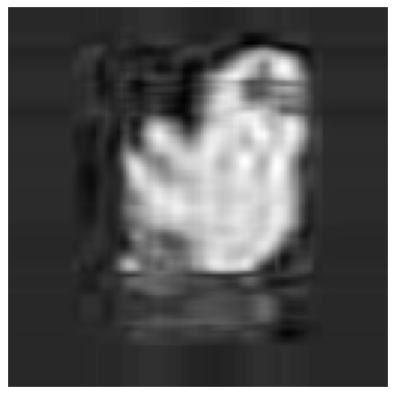

Latent image size = (16, 16)


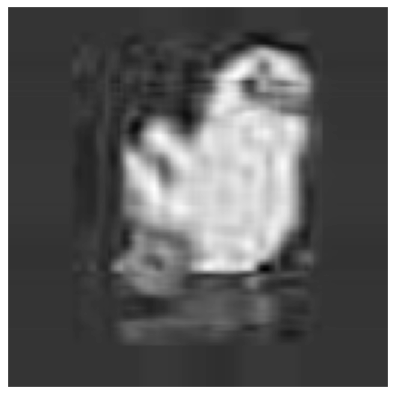

Latent image size = (20, 20)


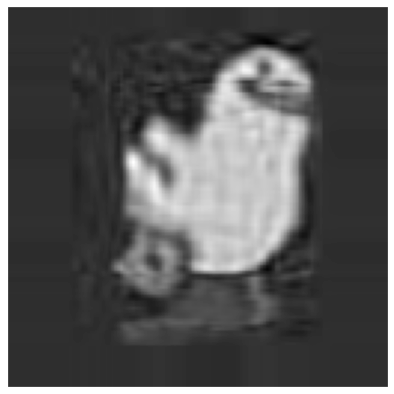

Latent image size = (32, 32)


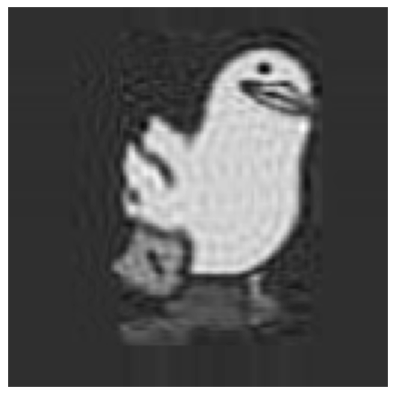

Latent image size = (48, 48)


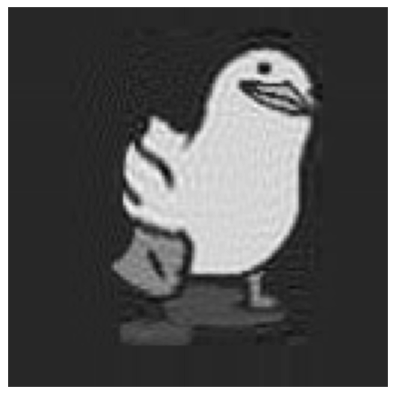

Latent image size = (64, 64)


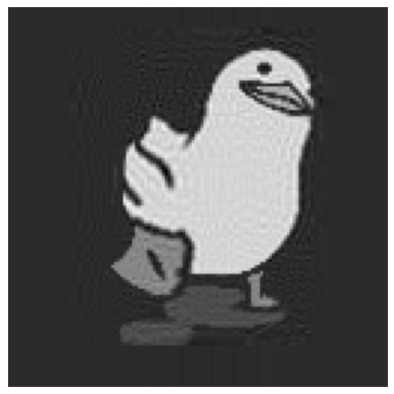

Latent image size = (128, 128)


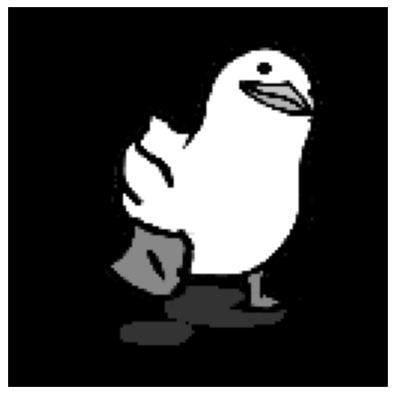

In [20]:
core_arr = (4, 8, 12, 16, 20, 32, 48, 64, 128)

for core_size in core_arr:
    tensor_tkd_hosvd, factor_matrices = hosvd_transform(
        duck_cartoon, 
        (duck_cartoon.shape[0], core_size, core_size)
    )
    
    recov = (
        tensor_tkd_hosvd.core
        .mode_n_product(factor_matrices[0], mode=0, inplace=False)
        .mode_n_product(factor_matrices[1], mode=1, inplace=False)
        .mode_n_product(factor_matrices[2], mode=2, inplace=False)
    )
    print(f"Latent image size = ({core_size}, {core_size})")
    plt.gray()
    plt.imshow(recov[0])
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f"approx_{core_size}.pdf")
    plt.show()

Далее будем работать с восстановленной гифкой с латентным размером картинки (20, 20)

In [21]:
LATENT_IMG_SIZE = 20

tensor_tkd_hosvd, factor_matrices = hosvd_transform(
    duck_cartoon, 
    (duck_cartoon.shape[0], LATENT_IMG_SIZE, LATENT_IMG_SIZE)
)

recov = (
    tensor_tkd_hosvd.core
    .mode_n_product(factor_matrices[0], mode=0, inplace=False)
    .mode_n_product(factor_matrices[1], mode=1, inplace=False)
    .mode_n_product(factor_matrices[2], mode=2, inplace=False)
)

## Применение метода CCM для исследования связи между звуком и набором изображений

Продублируем восстановленную гифку 5 раз.  
Тогда общее число кадроб будет равно 15 * 5 = 75  

Предположим, что звуковой сигнал имеет синусоидную форму с нормальным шумом:  

$$ Y = \left\{\sin\left(i * \frac{4 \pi}{15} \right) + \xi_i \right\}_{i=1}^{75} \text{, где } \xi_i \sim \mathcal{N}(0, 0.1^2) $$

In [24]:
np.random.seed(SEED)

N_REPEATS = 5
EMB_SIZE = duck_cartoon.shape[0]
repeated_gif = np.tile(recov.data, (N_REPEATS, 1, 1))

signal = np.sin(np.arange(repeated_gif.shape[0])*4*np.pi/EMB_SIZE)
signal += np.random.normal(0, 0.1, signal.shape)

Визуализация полученного звукового сигнала

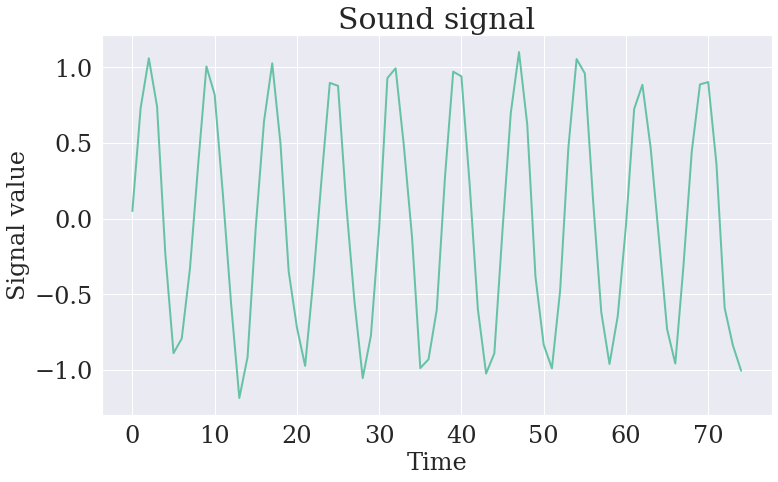

In [25]:
plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Signal value")
plt.title("Sound signal")
plt.grid(True)
plt.show()

Постороим траекторные матрицы для звука и для картинок

In [26]:
traj_signal = np.array([signal[i:i+EMB_SIZE] for i in range(len(signal)-EMB_SIZE+1)])
traj_cartoon = np.array([repeated_gif[i:i+EMB_SIZE] for i in range(len(repeated_gif)-EMB_SIZE+1)])

Проверка наличия связи `звук ==> картинка`
$$ \varphi: \mathbf{y}_0 \mapsto \widehat{\mathbf{x}_0} = \sum\limits_{i=1}^K w_i \mathbf{x}_i, \qquad 
	w_i = \dfrac{u_i}{\sum\limits_{j=1}^K u_j}, \qquad
	u_i = \exp \bigl( - \dfrac{\| \mathbf{y}_0 - \mathbf{y}_i \|_2}{\text{TEMPERATURE}} \bigr) \text{, где}$$
$y_0 \in \mathbb{R}^{15}$ - элемент траекторной матрицы звука,  
$\widehat{x_0} \in \mathbb{R}^{15 \times 20 \times 20}$ - элемент многомерной траекторной матрицы кадров,  
$K \in \mathbb{N}$ - количество элементов в траекторной матрице - 1.
1. Липшицевость отображения $\varphi$
$$ \| \varphi(\mathbf{y}_i) - \varphi(\mathbf{y}_j) \|_{\infty} \leqslant C \| \mathbf{y}_i - \mathbf{y}_j \|_2$$
$$ \dfrac{\| \mathbf{y}_i - \mathbf{y}_j \|_2}{\| \varphi(\mathbf{y}_i) - \varphi(\mathbf{y}_j) \|_{\infty}} \geqslant C^{-1}$$
2. Высокая корреляция между $\mathbf{y}_0$ и $\widehat{\mathbf{y}_0}$

In [27]:
# Рассматриваемые индексы i для Y, для которых вычисляется \varphi(Y[i]),
# по которым далее определяется липшицевость \varphi.
# Берём последние 15 элементов траекторной матрицы звука.
# Затем в цикле для каждого из них вычисляется значение функции \varphi (recov_frame)
func_domen_indices = range(len(traj_cartoon)-EMB_SIZE, len(traj_cartoon))
recov_frames = []

TEMPERATURE = 1

for i in func_domen_indices:
    sound_distances = []
    
    for j in range(i):
        sound_dist_ji = norm(traj_signal[j] - traj_signal[i], ord=2)
        sound_distances.append(sound_dist_ji)
        
    sound_distances = np.array(sound_distances)
    weights = np.exp(-sound_distances/TEMPERATURE)
    norm_weights = weights / weights.sum()
    
    recov_frame = np.sum(traj_cartoon[:i]*norm_weights.reshape(-1, 1, 1, 1),
                         axis=0)
    recov_frames.append(recov_frame)
    
recov_frames = np.array(recov_frames)

Получаем значения корреляции и отношения расстояний для оценки константы Липшица

In [44]:
corr_values = []
distances_ratio = []

for i in func_domen_indices:
    i0 = i - func_domen_indices[0]
    
    corr_values.append(np.corrcoef(
        recov_frames[i0].reshape(-1),
        traj_cartoon[i].reshape(-1)
    )[0, 1])
    
    for j0 in range(i0):
        j = i - i0 + j0
        
        sound_dist_ij = norm(traj_signal[j] - traj_signal[i], ord=2)
        frame_dist_ij = norm(recov_frames[j0].reshape(-1) - recov_frames[i0].reshape(-1), ord=np.inf)
        
        distances_ratio.append(sound_dist_ij / frame_dist_ij)

Визуализация коэфф-тов корреляций

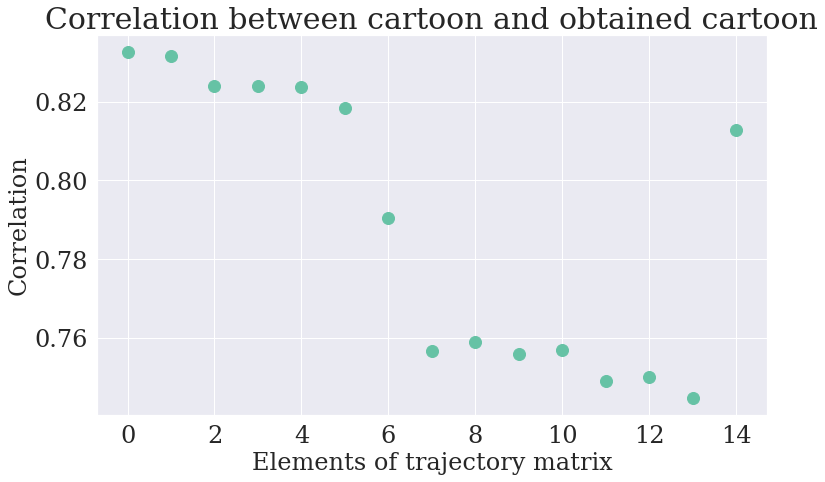

In [57]:
plt.title("Correlation between cartoon and obtained cartoon")
plt.scatter(range(len(corr_values)), corr_values)
plt.xlabel("Elements of trajectory matrix")
plt.ylabel("Correlation")
plt.savefig("correlation_plot.png")
plt.show()

**Вывод:** $\rho > 0.74$, поэтому временные ряды можно считать связными

Визуализация отношения расстояний

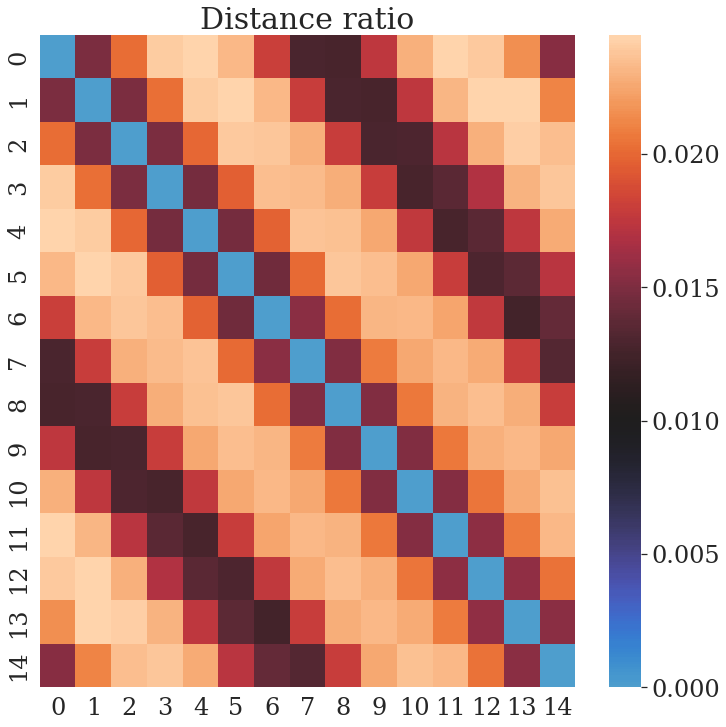

In [60]:
dist_ratio_tbl = np.zeros((len(func_domen_indices), len(func_domen_indices)))

for i in range(len(func_domen_indices)):
    for j in range(len(func_domen_indices)):
        if i == j:
            continue
        elif i > j:
            dist_ratio_tbl[i, j] = dist_ratio_tbl[j, i]
        else:
            ind = j * (j - 1) // 2 + i
            dist_ratio_tbl[i, j] = distances_ratio[ind]

plt.figure(figsize=(12, 12))
sns.heatmap(dist_ratio_tbl, center=0.01)
plt.title("Distance ratio")
plt.savefig("dist_ratio_table.png")
plt.show()

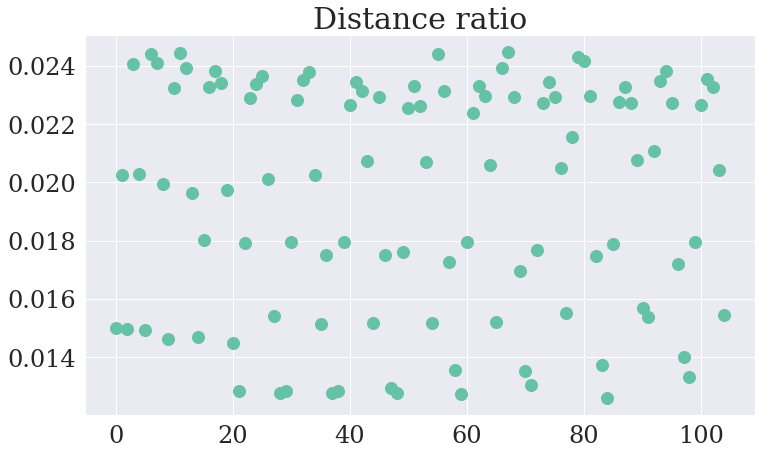

In [58]:
plt.scatter(range(len(distances_ratio)), distances_ratio)
plt.title("Distance ratio")
plt.savefig("dist_ratio_plot.png")
plt.show()

**Вывод:** $C^{-1} \geqslant 0.01 \Leftrightarrow C \leqslant 100$, временные ряды можно считать связанными